In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages

from uncertainties import ufloat
from uncertainties.unumpy import (nominal_values as noms,
                                  std_devs as stds)
from pandas_summary import DataFrameSummary
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
#from sklearn.feature_selection import mutual_info_classif
#from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.neural_network import MLPRegressor
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr



pandas2ri.activate()

zBackgroundPath = 'Daten/background.csv'
zSignalPath = 'Daten/signal.csv'
zPreparedDataPath = 'Daten/data.csv'
zSelDataPath = 'Daten/selData.csv'

zTargetFeature = 'IsSignal'

In [2]:
#Schmeisst Features mit zu hohen unvollstaendigkeiten raus
def cleaningFeatures(pData, pRelMaxMissing=0.75):
    vDataSummary = DataFrameSummary(pData)                       # Bestimme Feature Infos
    vCleanedData = pData.copy()
    
    vColumns = vDataSummary.columns_stats                        # Bestimme die Lister der Columns

    for fea in vColumns:
        vTemp = vDataSummary.columns_stats[fea]                  # Bekomme die Infos eines Features
    
        #print(fea[0:5])
    
        if fea == 'NewID' :                                         # Prueft, ob ID
            del vCleanedData[fea]
        elif fea[0] == 'M' and fea[1] == 'C':                    # Schmeißt die MC Wahrheiten mit MC raus
            del vCleanedData[fea]
        elif fea[0] == 'I' and fea[1] == '3':                    # Schmeißt die MC Wahrheiten mit I3 raus
            del vCleanedData[fea]
        elif fea[0:6] == 'Weight':                               # Schmeißt die MC Wahrheiten mit Weight raus
            del vCleanedData[fea]
        elif fea[0:7] == 'Corsika':                              # Schmeißt die MC Wahrheiten mit Corsika raus
            del vCleanedData[fea]
        elif (vTemp[2]/(vTemp[0]+vTemp[2])) >= pRelMaxMissing:   # Prueft ob ausreichend vollstaendig
            del vCleanedData[fea]
        elif vTemp[1] <= 1:                                      # Prueft ob Konstante
            del vCleanedData[fea]
            
    return vCleanedData

# Ersaetzt unbrauchbare Werte (NaN, etc,) und transformiert nicht numerische Spalten in numerische um
#    Woerterbuch wird nich angelegt, koennte ggf. noch.
def replaceValues(pData, pTransform=False):
    vScaler = StandardScaler()
    vDataSummary = DataFrameSummary(pData)
    
    for col in pData.columns.values:
        if vDataSummary.columns_stats[col][4] != 'numeric':      # Ersetzt alle nicht numerischen Werte durcdh numerisch
            vEleList = pData[col].value_counts().index.values    #     und fuellt falsche Eintraege (NaN, etc) mit 0
            vReplacements = np.linspace(1, len(vEleList), len(vEleList))
            
            pData[col] = pData[col].replace(to_replace=vEleList, value=vReplacements)
            pData[col] = pData[col].fillna(0)
        elif pData[col].dtype == 'int64':                        # Fuellt fuer Integer Spalten falsche Eintraege mit 0
            pData[col] = pData[col].fillna(0)
            #pData[col] = vScaler.fit_transform(pData[col])
        else:                                                     # Fuellt kontinuierliche Eintraege mit dem durchschnitt.
            pData[col] = pData[col].fillna(pData[col].mean())
            #pData[col] = vScaler.fit_transform(pData[col])
            
    return pData


# Bereitet die Features beider Datensaetze soweit vor und vereint sie beide.
#    zu unvollständige Features werden raus geschmiessen, 'IsSignal' Feature wird hinzugefuegt, ungeteilte Features werden rausgeschmiessen. 
def joinDataFrames(pData1, pData2):
    vData1 = cleaningFeatures(pData1)         # Schmeisst diejenigen Features raus, welche zu unvollstaendig sind
    vData2 = cleaningFeatures(pData2)
    
    vData1.insert(0, 'IsSignal', np.zeros(len(vData1.index))) # Fuegt 'IsSignal' Feature hin zu, um zu kennzeichnen,
    vData2.insert(0, 'IsSignal', np.ones(len(vData2.index)))  #    ob die Daten Signal '1', oder Untergrund '0' sind-
    
    vColumns1 = vData1.columns           # Holt sich die Features aus den Daten
    vColumns2 = vData2.axes[1]
    
    vSelFeature = vColumns1.intersection(vColumns2)    # Sucht alle Features die in beiden Datensaetzen drin sind
    
    vData1 = vData1.filter(items=vSelFeature)    # Selektiert die "einzigartigen" Features raus
    vData2 = vData2.filter(items=vSelFeature)
    
    vReturn = vData1.append(vData2)              # Vereint beide Datensätze, Rows sind doppelt!!!
    
    vReturn = replaceValues(vReturn)             # Ersetze nicht numerische durch numerische Daten, und falsche Daten durch 0 oder Durchschnitt.
    
    return vReturn
                

In [3]:
vBackgroundData = pd.read_csv(zBackgroundPath)            # Laed Background und Signal Daten
vSignalData = pd.read_csv(zSignalPath)

vData = joinDataFrames(vBackgroundData, vSignalData)      # Vereint diese nach Vorbereiten
print(vData)
vData.to_csv(zPreparedDataPath)                           # Speichert die Vorbereiteten Daten

       IsSignal  HitMultiplicityValues.n_hit_strings  \
0           2.0                                  5.0   
1           2.0                                  4.0   
2           2.0                                  4.0   
3           2.0                                  5.0   
4           2.0                                  4.0   
5           2.0                                  5.0   
6           2.0                                  7.0   
7           2.0                                  6.0   
8           2.0                                  5.0   
9           2.0                                  4.0   
10          2.0                                  5.0   
11          2.0                                  7.0   
12          2.0                                  7.0   
13          2.0                                  4.0   
14          2.0                                 11.0   
15          2.0                                  8.0   
16          2.0                                 

In [4]:
def plotPhis(pPhis):
    vX = range(1, len(pPhis)+1)
    
    plt.plot(vX, noms(np.array(pPhis)), 'r-')
    plt.errorbar(vX, noms(np.array(pPhis)), yerr=stds(np.array(pPhis)), color='k', fmt='x')
    
    #plt.ylim(-0.05, 1.05)
    plt.xlabel('Anzahl an Bestfeatures', {'size':'16'})
    plt.ylabel('$\Phi$', {'size':'16'})
    plt.title('$\Phi$-Scores')
    plt.legend(loc='best', prop={'size':16})
    plt.tight_layout()
    plt.savefig('Bilder/PhiScores.pdf')
    plt.show()
    plt.clf()

def plotJaccard(pJaccard):
    vX = range(1, len(pJaccard)+1)
    
    plt.plot(vX, np.array(pJaccard), 'r-')
    
    #plt.ylim(-0.05, 1.05)
    plt.xlabel('Anzahl an Bestfeatures', {'size':'16'})
    plt.ylabel('Jaccard-Index', {'size':'16'})
    plt.title('Jaccard-Scores')
    plt.legend(loc='best', prop={'size':16})
    plt.tight_layout()
    plt.savefig('Bilder/JScores.pdf')
    plt.show()
    plt.clf()

In [5]:
# Berechnet den Jaccard-Index zweier Mengen
def calJ(pQuantity1, pQuantity2):
    vEq = 0
    
    for i in range(0, len(pQuantity1)):
        for u in range(0, len(pQuantity2)):
            if pQuantity1[i] == pQuantity2[u]:
                vEq += 1
                
    return (vEq)/(len(pQuantity1)+len(pQuantity2)-vEq)


# Berechnet den Jaccard-Index der Selektierten Features 
def calJaccardIndex(pSelectedFeatures):
    vRet = 0
    vL = len(pSelectedFeatures)
    
    for i in range(0, vL):
        for u in range(i+1, vL):
            vRet += calJ(pSelectedFeatures[i], pSelectedFeatures[u])
            
    return vRet*(2/(vL*(vL-1)))
    
    
            
# Berechnet das Phi fuer den MRMR, wobei pMutInfoArray, eine gepatterte mutualInformationMatrix zwischen den jeweiligen Featuren ist.
def calPhi(pMutInfoArray, pTarFeatID, pSelFeatID, pFeatLen):
    vD, vR = 0, 0
    
    for i in range(0, len(pSelFeatID)):                               # geht die Anzahl an BestFeature durch
        vD += pMutInfoArray[((pTarFeatID-1)*pFeatLen)+(pSelFeatID[i]-1)]             # Gibt die zwischen Information zum Target an
        for u in range(0, len(pSelFeatID)):                           # Geht die zwischen Informationen mit den anderen BestFeatures durch
            if i != u:
                vR += pMutInfoArray[((pSelFeatID[i]-1)*pFeatLen)+(pSelFeatID[u]-1)]
    
    if vR != 0:                                                       # Berechnet den Phi Score
        vRet = (vD/len(pSelFeatID)) / (vR/(len(pSelFeatID)**2))
    else:
        vRet = (vD/len(pSelFeatID)) 
    
    return vRet

# Berechnet mit dem MRMR algorythmus fuer R die Besten n Features, wobei aus n aus aus der bis zu pK maximalen Anzahl bestFeature gesucht wird.
def calMRMRe(pData, pTargetFeature, pK=50, pL=5):
    vRet, vPhis, vJaccards = [], [], []
    
    mRMRe=importr('mRMRe')                       # Import die mRMRe Biblieothek fuer R
    mRMRe.set_thread_count(3)                    # Setzt die Anzahl an parallel Arbeitenden Kernen

    vTarID = pData.columns.tolist().index(pTargetFeature)+1      # Bestimmt die TargetFeature ID fuer R-Zaehlung
    
    #rData = pandas2ri.py2ri(pData)               # Wandel die Daten von Panda in R um
    #rMRMReData = mRMRe.mRMR_data(rData)          # Wandel die Daten in ein Format fuer mRMRe um
    #
    #for i in range(1, pK+1):                                     # Berechnet fuer bis zu pK Anzahlen an BestFeatures die
    #    rMRMR_classic = mRMRe.mRMR_classic(data=rMRMReData, target_indices=vTarID, feature_count=i, continuous_estimator
#='spearman')   # besten Features und
    #                                                                                                  # und die entsprechenden
    #    vPhis += [calPhi(mRMRe.mim(rMRMR_classic), vTarID, mRMRe.solutions(rMRMR_classic)[0], len(pData.columns))]        # Phio Scores.
    #print(mRMRe.mim(rMRMR_classic))
    #print(vPhis)
    #plotPhis(vPhis)
    
    #vMaxPhiID = np.array(vPhis).argmax()                                                              # Bestimmt die Anzahl an BestFeatures mit den besten Score
    #rMRMR_classic = mRMRe.mRMR_classic(data=rMRMReData, target_indices=vTarID, feature_count=vMaxPhiID+1) # Bestimmt die BestFeatures fuer diese Anzahl neu
    
    vDataSets = splitData(pData, pL, 0.3, 0.0)
    
    for i in range(1, pK+1):
        vBestFeatSets = []
        vTempPhis = []
        for u in range(0, pL):
            rData = pandas2ri.py2ri(vDataSets[u][0])               # Wandel die Daten von Panda in R um
            rMRMReData = mRMRe.mRMR_data(rData)                    # Wandel die Daten in ein Format fuer mRMRe um
        
            rMRMR_classic = mRMRe.mRMR_classic(data=rMRMReData, target_indices=vTarID, feature_count=i, continuous_estimator='spearman')
            vBestFeatSets += [mRMRe.solutions(rMRMR_classic)[0]]
            vTempPhis += [calPhi(mRMRe.mim(rMRMR_classic), vTarID, mRMRe.solutions(rMRMR_classic)[0], len(pData.columns))]        # Phi Scores.
        vTempPhis = np.array(vTempPhis)
        
        vJaccards += [calJaccardIndex(vBestFeatSets)]
        vPhis += [ufloat(np.mean(vTempPhis), np.std(vTempPhis))]
        print(i)
        
    #print(vJaccards)
    
    vMaxJID = np.array(vJaccards)[2:].argmax()
    vMaxPhiID = np.array(vPhis).argmax()                                                              # Bestimmt die Anzahl an BestFeatures mit den besten Score
    rMRMR_classic = mRMRe.mRMR_classic(data=rMRMReData, target_indices=vTarID, feature_count=vMaxJID+3) # Bestimmt die BestFeatures fuer diese Anzahl neu
    
    for i in range(0, len(mRMRe.solutions(rMRMR_classic)[0])):                    # Bestimmt aus den ID der BestFeatures
        vRet += [pData.columns.tolist()[mRMRe.solutions(rMRMR_classic)[0][i]-1]]  #   die Features
    
    #vDataSets = splitData(pData, pL, 0.3, 0.0)
    #vBestFeatSets = []
    #for i in range(0, len(vDataSets)):
    #    rData = pandas2ri.py2ri(vDataSets[i][0])               # Wandel die Daten von Panda in R um
    #    rMRMReData = mRMRe.mRMR_data(rData)                    # Wandel die Daten in ein Format fuer mRMRe um
    #    
    #    rMRMR_classic = mRMRe.mRMR_classic(data=rMRMReData, target_indices=vTarID, feature_count=vMaxPhiID+1)
    #    vBestFeatSets += [mRMRe.solutions(rMRMR_classic)[0]]
    #vJ = calJaccardIndex(vBestFeatSets)
    
    return vRet, vPhis, vJaccards            

In [9]:
vData = pd.read_csv(zPreparedDataPath)                # Laed die vorbearbeiteten Daten ein
del vData[vData.columns[0]]                           # Entfernt die erste Zeile, da leider unfugszeile

#vMaxJID = np.array(vJaccards)[2:].argmax()
#vMaxPhiID = np.array(vPhis).argmax()                  # Bestimmt die Anzahl an BestFeatures mit den besten Score

#mRMRe=importr('mRMRe')                       # Import die mRMRe Biblieothek fuer R
#mRMRe.set_thread_count(3)                    # Setzt die Anzahl an parallel Arbeitenden Kernen
#vTarID = vData.columns.tolist().index(zTargetFeature)+1
#rData = pandas2ri.py2ri(vData)                        # Wandel die Daten von Panda in R um
#rMRMReData = mRMRe.mRMR_data(rData)
#rMRMR_classic = mRMRe.mRMR_classic(data=rMRMReData, target_indices=vTarID, feature_count=vMaxJID+3) # Bestimmt die BestFeatures fuer diese Anzahl neu

#vSelFeatures = []
#for i in range(0, len(mRMRe.solutions(rMRMR_classic)[0])):                    # Bestimmt aus den ID der BestFeatures
#    vSelFeatures += [vData.columns.tolist()[mRMRe.solutions(rMRMR_classic)[0][i]-1]]  #   die Features

vSelFeatures, vPhis, vJaccards = calMRMRe(vData, 'IsSignal', 40, 20)# Bestimmt mit MRMR die BestFeatures
vSelFeatures.insert(0, zTargetFeature)                # Fuegt zu den BestFeature das TargetFeature hinzu

plotPhis(vPhis)
plotJaccard(vJaccards)
#print(vPhis)
#print(vJaccards)
print(vSelFeatures)

vSelData = vData[vSelFeatures]                        # Holt sich die Daten fuer die Selektierten Features
vSelData.to_csv(zSelDataPath)                         # Speichert die nun selektierten Features ab.

1


KeyboardInterrupt: 

In [8]:
# Splitte die Daten fuer eine Kreuzvalidierung in pK zufaellige gezogene Sets auf, mit je pTrain anteilen an Trainingsdaten und
#     pTest Anteilen an Testdaten.
def splitData(pData, pK, pTrain=0.6, pTest=0.4):
    vRet = []
    for i in range(0, pK):
        vRet += [train_test_split(pData, train_size=pTrain, test_size=pTest, random_state=(2407+(i*100)))]
                                  
    return vRet

# Berechnet die Reinheit und Effizienz fuer eine Anwendung des NaivesBayes aus das Datenset
def calNavBay(pTrainData, pTestData, pTarTrainData, pTarTestData, pStepLength):
    vNavBay = MultinomialNB()                   # Initialisiert den NaiveBayes
    
                                                # Verschiebt die Werte dieses Features in den positiven Bereich, da der Lernen
    vTrainMin = pTrainData[pTrainData.columns[0]].min()   # nur mit positiven Werten funktioniert.
    vTestMin = pTestData[pTestData.columns[0]].min()      # Hierfuer wird der niedrigste Wert des Datenset dieses Features bestimmt

    if vTrainMin > vTestMin:                               # Und dann um den Wert verschoben
        pTrainData[pTrainData.columns[0]] = pTrainData[pTrainData.columns[0]]  - vTestMin
        pTestData[pTestData.columns[0]] = pTestData[pTestData.columns[0]] - vTestMin
    else:
        pTrainData[pTrainData.columns[0]] = pTrainData[pTrainData.columns[0]]  - vTrainMin
        pTestData[pTestData.columns[0]] = pTestData[pTestData.columns[0]] - vTrainMin
    
    for i in range(0, len(pTrainData.columns)):
        vTrainMin = pTrainData[pTrainData.columns[i]].min()   # nur mit positiven Werten funktioniert.
        vTestMin = pTestData[pTestData.columns[i]].min()      # Hierfuer wird der niedrigste Wert des Datenset dieses Features bestimmt
        
        if vTrainMin < 0 or vTestMin < 0:
            if vTrainMin > vTestMin:                               # Und dann um den Wert verschoben
                pTrainData[pTrainData.columns[i]] = pTrainData[pTrainData.columns[i]]  - vTestMin
                pTestData[pTestData.columns[i]] = pTestData[pTestData.columns[i]] - vTestMin
            else:
                pTrainData[pTrainData.columns[i]] = pTrainData[pTrainData.columns[i]]  - vTrainMin
                pTestData[pTestData.columns[i]] = pTestData[pTestData.columns[i]] - vTrainMin
    
    vNavBay.fit(pTrainData, pTarTrainData)                 # Trainiert den NaiveBayes  
    vTarEstData = vNavBay.predict_proba(pTestData)         # Macht vorrausage für Test Daten
    
    vScores = calPurAndEff(pTarTestData, vTarEstData, pStepLength)   # Vergelicht Vorrausgesagte Daten mit Test Daten und berechnet
                                                #    die Reinheit und die Effizienz
    return vScores
    

In [3]:
def calrand(pTrainData, pTestData, vTarTrainData, vTarTestData, pStepLength):
    clf = RandomForestClassifier(n_estimators=300, max_depth=30)    # Initialisiert den Random Forest
    #300 Baueme, Tiefe 30, 
    
    clf.fit(pTrainData, vTarTrainData)      # Trainiert den Random Forest
    vTarEstData = clf.predict_proba(pTestData)    # Macht vorrausage für Test Daten
    
    vScores = calPurAndEff(vTarTestData, vTarEstData, pStepLength)   # Vergelicht Vorrausgesagte Daten mit Test Daten und berechnet
                                                #    die Reinheit und die Effizienz
    return vScores
    

In [4]:
def calKNN(pTrainData, pTestData, vTarTrainData, vTarTestData, pStepLength):
    kn = KNeighborsClassifier(n_neighbors=6)    # Initialisiert den Random Forest
    #6 Nachbern
    
    kn.fit(pTrainData, vTarTrainData)      # Trainiert den Random Forest
    vTarEstData = kn.predict_proba(pTestData)    # Macht vorrausage für Test Daten
    
    vScores = calPurAndEff(vTarTestData, vTarEstData, pStepLength)   # Vergelicht Vorrausgesagte Daten mit Test Daten und berechnet
                                                #    die Reinheit und die Effizienz
    return vScores
    

In [15]:
# Berechnet die Reinheit und die Effizienz fuer das Zeildaten durch Vergleich der vorhergesagten
#     und der test Daten al eine Matrix, für verschiede Konfidenzgrenzen der Form [[Reinheit_1, Effizienz_1], [_2, _2]]
def calPurAndEff(pTestData, pEstData, pStepLength=100):
    vRet = []
    
    for i in range(0, pStepLength):                         # Berechnet pro Konvidenzintervall
        vEstData = np.ones(len(pTestData))                  # Erstellt alle als Untergrund erkannt
        vEstData[pEstData.T[1] >= (i)/(pStepLength-1)] = 2  # Bestimmt das ab der Konfidenzintervallgrenze der Wert als
                                                            #    Signal interpretiert wird.
        vTP = pTestData[vEstData == pTestData]           # Bestimmt die Anzahl an richtig als Signal erkannten Daten
        vTP = len(vTP[vTP == 2])                             
    
        if len(vEstData[vEstData == 2]) != 0:
            vPurity = vTP/(len(vEstData[vEstData == 2]))        # Bestimmt die Reinheit aus TP und der Anzahl an Daten die als Signal vorrausgesagten wurden
        else:
            vPurity = -1
        if len(pTestData[pTestData == 2]) != 0:
            vEfficiency = vTP/(len(pTestData[pTestData == 2]))
        else:
            vEfficiency = -1
               
        vRet += [[vPurity, vEfficiency]]                    # Fuegt die Berechnet Reinheit und Effizienz fuer Konfidenzgrenze
                                                            #    der Ausgabe hinzu.
    return vRet

# Berechnet aus den ausgegeben Scores die durchschnitts Reinheit und Effiziens, sowie deren Abweichung.
def evaScores(pScores, pRound=3):
    vPurs = pScores[:, :, 0]                         # Waehlt alle Reinheiten aus
    vEffs = pScores[:, :, 1]                         # Waehlt alle Effizienzen aus
    
    vMeanPurity, vMeanEfficiens = np.array(vPurs[0]), np.array(vEffs[0])    # Berechnet den Mittelwert aus den Reinheits
    for i in range(1, len(vPurs)):                                          #    der einzelnen Samples, getrennt
        vMeanPurity = vMeanPurity + np.array(vPurs[i])                      #    fuer jeden einzelnen Konfidenzlevel
        vMeanEfficiens = vMeanEfficiens + np.array(vEffs[i])
    vMeanPurity = vMeanPurity/len(vPurs)
    vMeanEfficiens = vMeanEfficiens/len(vEffs)
    
    vStdPurity = (vMeanPurity - np.array(vPurs[0]))**2                      # Gleiches wie beim Mittelwert fuer die Standartabweichung
    vStdEfficiens = (vMeanEfficiens - np.array(vEffs[0]))**2
    for i in range(1, len(vPurs)):
        vStdPurity = vStdPurity + (vMeanPurity - np.array(vPurs[i]))**2
        vStdEfficiens = vStdEfficiens + (vMeanEfficiens - np.array(vEffs[i]))**2
    vStdPurity = np.sqrt(vStdPurity/(len(vPurs)-1))
    vStdEfficiens = np.sqrt(vStdEfficiens/(len(vPurs)-1))
    
    vPurity = unp.uarray(vMeanPurity, vStdPurity)                       # Fuegt Mittelwert und Standarabweichung zusammen
    vEfficiens = unp.uarray(vMeanEfficiens, vStdEfficiens)
    
    return vPurity, vEfficiens
        
def printScores(pScores, pID):
    vX = np.linspace(0, 100, len(pScores[0]))
    
    if pID == 0:
        vTitle = 'NaiveBayes'
    elif pID == 1:
        vTitle = 'RandomForest'
    elif pID == 2:
        vTitle = 'KNN'
    else:
        vTitle = 'Default'
    
    plt.errorbar(vX, noms(pScores[0]), yerr=stds(pScores[0]), color='g', fmt=',', label='Reinheit')
    plt.errorbar(vX, noms(pScores[1]), yerr=stds(pScores[1]), color='b', fmt=',', label='Effizienz')
    plt.plot(vX, noms(pScores[0]), 'g-')
    plt.plot(vX, noms(pScores[1]), 'b-')
    
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Konfidenzniveau in %', {'size':'16'})
    plt.ylabel('Wert', {'size':'16'})
    plt.title(vTitle)
    plt.legend(loc='best', prop={'size':16})
    plt.tight_layout()
    plt.savefig('Bilder/'+vTitle+'.pdf')
    plt.show()
    plt.clf()

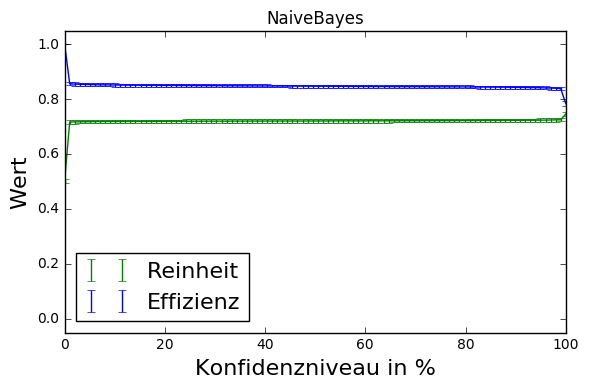

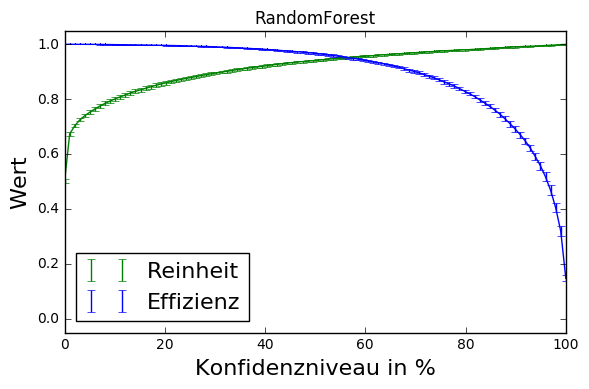

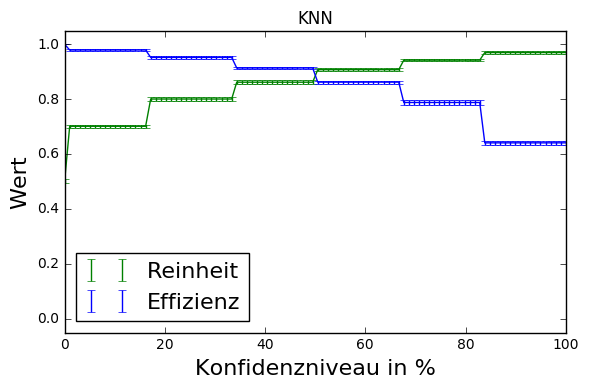

In [16]:
printScores(vNavScores, 0)
printScores(vRanScores, 1)
printScores(vKnnScores, 2)

In [10]:
vStepLength = 100

vSelData = pd.read_csv(zSelDataPath)                     # Laed die selektierten Daten
del vSelData[vSelData.columns[0]]                        # Loescht die erste Unfugszeile

vDataSets = splitData(vSelData, 10, 0.3, 0.2)            # Splittet die Daten in 10 Datensets
vNavScores = []                                          # Initialisiert die ScoreArray der verschidenen Lerner
vRanScores = []                                          #   Aufbau [[Reinheit_1, Effiziens_1], [_2, _2], ...]
vKnnScores = []                                          #

for i in range(0, len(vDataSets)):                       # Laesst alle Datensets von den Lernen bearbeiten und speichert die entsprechenden Scres
    pTrainData  = vDataSets[i][0]
    pTestData   = vDataSets[i][1]
                            
    vTarTrainData = pTrainData[zTargetFeature]        # Separiert die TargetFeature Daten 
    vTarTestData = pTestData[zTargetFeature]
    del pTrainData[zTargetFeature]
    del pTestData[zTargetFeature]
                            
    vNavScores += [calNavBay(pTrainData, pTestData, vTarTrainData, vTarTestData, vStepLength)]
    vRanScores += [calrand(pTrainData, pTestData, vTarTrainData, vTarTestData, vStepLength)]
    vKnnScores += [calKNN(pTrainData, pTestData, vTarTrainData, vTarTestData, vStepLength)]

vNavScores = evaScores(np.array(vNavScores))              # Berechnet aus den ScoreArrays den Mittelwert der Reinheit und 
vRanScores = evaScores(np.array(vRanScores))              #      der Effiziens, sowie Standardabweichung
vKnnScores = evaScores(np.array(vKnnScores))              #      der Effiziens, sowie Standardabweichung

printScores(vNavScores, 0)
printScores(vRanScores, 1)
printScores(vKnnScores, 2)
#print(vNavScores)
#print(vRanScores)   

/home/dh/.local/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dh/.local/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dh/.local/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

TypeError: __init__() got an unexpected keyword argument 'font'

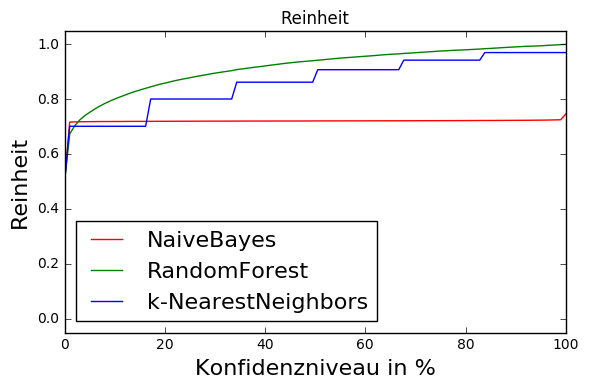

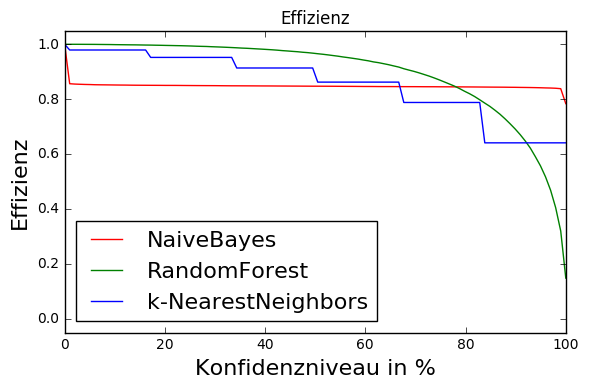

In [17]:
vX = np.linspace(0, 100, len(vNavScores[0]))
    
plt.plot(vX, noms(vNavScores[0]), 'r-', label='NaiveBayes')
plt.plot(vX, noms(vRanScores[0]), 'g-', label='RandomForest')
plt.plot(vX, noms(vKnnScores[0]), 'b-', label='k-NearestNeighbors')
    
plt.ylim(-0.05, 1.05)
plt.xlabel('Konfidenzniveau in %', {'size':'16'})
plt.ylabel('Reinheit', {'size':'16'})
plt.title('Reinheit')
plt.legend(loc='best', prop={'size':16})
plt.tight_layout()
plt.savefig('Bilder/Purity.pdf')
plt.show()
plt.clf()

plt.plot(vX, noms(vNavScores[1]), 'r-', label='NaiveBayes')
plt.plot(vX, noms(vRanScores[1]), 'g-', label='RandomForest')
plt.plot(vX, noms(vKnnScores[1]), 'b-', label='k-NearestNeighbors')

plt.ylim(-0.05, 1.05)
plt.xlabel('Konfidenzniveau in %', {'size':'16'})
plt.ylabel('Effizienz', {'size':'16'})
plt.title('Effizienz')
plt.legend(loc='best', prop={'size':16})
plt.tight_layout()
plt.savefig('Bilder/Efficiency.pdf')
plt.show()
plt.clf()

# print(stds(vKnnScores[0]))
print(stds(vKnnScores[1]))